In [2]:
import torch
import torch.optim
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
from torch.utils import data
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torchvision.transforms.functional as functional
from skimage import io, transform
import torch.nn as nn
import torch.optim as optim
import copy
import torchvision
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from PIL import Image
import cv2
import pdb,tqdm
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def show_image(filename):
    img = mpimg.imread('../data/train/images/'+filename)
    imgplot = plt.imshow(img)
    plt.show()

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
train_files = pd.read_csv('../data/train/train.csv')
test_files = pd.read_csv('../data/test_ApKoW4T.csv')

In [6]:
temp = Image.open(os.path.join('../data/train/images','683110.jpg'))

In [22]:
class deep_learning_data(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None,y=True):
        
        self.root_dir = root_dir
        self.transform = transform
        self.files = pd.read_csv(csv_file)
        self.y = y
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                               self.files.iloc[idx,0])
        image = Image.fromarray(cv2.imread(img_name))
        if self.transform:
            image = self.transform(image)
        if (np.array(image.size()) == np.array([1,224,224])).all():
            print(img_name)

        return (image, self.files.iloc[idx,1]-1)
        

In [28]:
img_transforms = {
    'train': 
    transforms.Compose([
#         transforms.RandomResizedCrop(size = 256, scale=(0.8,1.0)),
#         transforms.RandomRotation(degrees = 15),
#         transforms.ColorJitter(),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size = 224),
        transforms.Resize(size =(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    
    'valid':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
#         transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
}

In [29]:
train_dataset= deep_learning_data(csv_file = '../data/train/train.csv',
                                 root_dir = '../data/train/images',
                                 transform = img_transforms['train'])
# test_dataset = deep_learning_data(csv_file = '../data/test_ApKoW4T.csv',
#                                  root_dir = '../data/train/images',
#                                  transform = img_transforms['valid'])

In [49]:
train_dataloader = DataLoader(train_dataset,batch_size = 12,
                       shuffle = True, num_workers = 4)

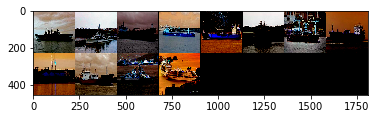

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [12]:
from torchvision import models

In [51]:
num_classes = 5
model = models.resnet101(pretrained=False)
set_parameter_requires_grad(model,True)
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, num_classes)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
input_size = 224

In [21]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
# model = ResNet(ResidualBlock, [2,2,2]).to(device)

In [52]:
params_to_update = model.parameters()
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t',name)

	 fc.weight
	 fc.bias


In [53]:
optimizer = optim.SGD(params_to_update, lr= 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [54]:
model = model.cuda()
model = nn.DataParallel(model)

In [55]:
n_epochs = 20

val_acc_history = []

# best_model_wts = copy.deepcopy(model.cpu().state_dict())

best_acc = 0.0
t = tqdm.tqdm_notebook(range(n_epochs))
k = tqdm.tqdm_notebook(train_dataloader)
for epoch in t:
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in k:
#             pdb.set_trace()
#             print(inputs.shape)
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs,1)

        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    
    print('{} Loss : {:.4f} Acc: {:.4f}'.format('Train',epoch_loss,epoch_acc))

# model.load_state_dict(best_model_wts)

Train Loss : 0.0033 Acc: 0.0005
Train Loss : 0.0041 Acc: 0.0003
Train Loss : 0.0033 Acc: 0.0003
Train Loss : 0.0033 Acc: 0.0003
Train Loss : 0.0040 Acc: 0.0002
Train Loss : 0.0033 Acc: 0.0003
Train Loss : 0.0038 Acc: 0.0002
Train Loss : 0.0041 Acc: 0.0000
Train Loss : 0.0040 Acc: 0.0008
Train Loss : 0.0036 Acc: 0.0003
Train Loss : 0.0042 Acc: 0.0006
Train Loss : 0.0032 Acc: 0.0005
Train Loss : 0.0030 Acc: 0.0005
Train Loss : 0.0040 Acc: 0.0006
Train Loss : 0.0031 Acc: 0.0008
Train Loss : 0.0027 Acc: 0.0008
Train Loss : 0.0050 Acc: 0.0005
Train Loss : 0.0032 Acc: 0.0002
Train Loss : 0.0025 Acc: 0.0011
Train Loss : 0.0033 Acc: 0.0006


In [57]:
outputs,labels

(tensor([[ 0.4472,  0.5392,  0.5758,  0.3173, -0.6830],
         [ 0.9762, -0.0185,  1.1549, -0.0827, -0.7348],
         [ 1.4219,  0.6010,  0.4793, -0.0957, -0.8416],
         [ 1.1495,  2.0093,  1.2742,  0.3750, -0.9119],
         [ 0.9508,  0.3739,  0.2587, -0.7268, -0.0946],
         [ 0.7517,  0.3639,  0.2690, -0.4892,  0.0301],
         [ 1.6158,  1.3846,  0.0123,  0.3492, -1.2049],
         [ 1.9726, -0.8144,  1.4166, -0.0063,  0.1785],
         [ 0.0757,  1.2509,  0.4445, -0.2782, -0.6719],
         [ 0.4268,  1.2988,  0.0083,  0.2511, -1.0609],
         [ 1.3078,  1.9564,  0.4360,  0.2964, -0.4850],
         [ 1.1586,  1.1281, -0.6713, -0.3661, -0.2560]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([2, 4, 1, 1, 1, 0, 1, 4, 2, 1, 4, 3], device='cuda:0'))